In [35]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle as pkl
import tensorflow as tf
import itertools

# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append('..')

import metrics

import warnings
warnings.filterwarnings('once')

In [94]:
def add_benchmarks(legend_loc=None):
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.plot([-0.5, 250.5], [13.176, 13.176], ls='--', c='C3', label='M4 winner', lw=2)
    plt.plot([-0.5, 250.5], [12.913, 12.913], ls='--', c='C4', label='N-BEATS', lw=2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.legend(loc=legend_loc)
    
def keep_duplicates(df, column):
    
    gb = df.groupby(column)

    for group in gb.groups:
        try:
            mask.merge(gb.get_group(group).drop([column, 'smape', 'mase*'], axis=1), how='inner')
        except NameError:
            mask = gb.get_group(group).drop([column, 'smape', 'mase*'], axis=1)
            
    results = [gb.get_group(group).merge(mask) for group in gb.groups]
    
    return pd.concat(results)

In [15]:
bi_300_false_model_params = 'inp_18__out_14__loss_mae__bksize_300__bkact_relu__dir_bi__'
conv_300_false_model_params = 'inp_18__out_14__loss_mae__bksize_300__bkact_relu__dir_conv__'
bi_600_false_model_params = 'inp_18__out_14__loss_mae__bksize_600__bkact_relu__dir_bi__'
conv_600_false_model_params = 'inp_18__out_14__loss_mae__bksize_600__bkact_relu__dir_conv__'
bi_300_true_model_params = 'aug__inp_18__out_14__loss_mae__bksize_300__bkact_relu__dir_bi__'
conv_300_true_model_params = 'aug__inp_18__out_14__loss_mae__bksize_300__bkact_relu__dir_conv__'
bi_600_true_model_params = 'aug__inp_18__out_14__loss_mae__bksize_600__bkact_relu__dir_bi__'
conv_600_true_model_params = 'aug__inp_18__out_14__loss_mae__bksize_600__bkact_relu__dir_conv__'

bi2_300_false_model_params = 'inp_18__out_14__loss_mae__bksize_300__bkact_relu__dir_bi2__'
conv2_300_false_model_params = 'inp_18__out_14__loss_mae__bksize_300__bkact_relu__dir_conv2__'
bi2_600_false_model_params = 'inp_18__out_14__loss_mae__bksize_600__bkact_relu__dir_bi2__'
conv2_600_false_model_params = 'inp_18__out_14__loss_mae__bksize_600__bkact_relu__dir_conv2__'
bi2_300_true_model_params = 'aug__inp_18__out_14__loss_mae__bksize_300__bkact_relu__dir_bi2__'
conv2_300_true_model_params = 'aug__inp_18__out_14__loss_mae__bksize_300__bkact_relu__dir_conv2__'
bi2_600_true_model_params = 'aug__inp_18__out_14__loss_mae__bksize_600__bkact_relu__dir_bi2__'
conv2_600_true_model_params = 'aug__inp_18__out_14__loss_mae__bksize_600__bkact_relu__dir_conv2__'

p = Path('../results').absolute()

model_dirs = [bi_300_false_model_params, conv_300_false_model_params, bi_600_false_model_params, 
              conv_600_false_model_params, bi_300_true_model_params, conv_300_true_model_params,
              bi_600_true_model_params, conv_600_true_model_params, bi2_300_false_model_params,
              conv2_300_false_model_params, bi2_600_false_model_params, conv2_600_false_model_params,
              bi2_300_true_model_params, conv2_300_true_model_params, bi2_600_true_model_params, 
              conv2_600_true_model_params]

model_names = ['bi_300_false', 'conv_300_false', 'bi_600_false', 'conv_600_false', 'bi_300_true', 
               'conv_300_true', 'bi_600_true', 'conv_600_true', 'bi2_300_false', 'conv2_300_false',
               'bi2_600_false', 'conv2_600_false', 'bi2_300_true', 'conv2_300_true', 'bi2_600_true', 
               'conv2_600_true']

models = []

for model_dir in model_dirs:
    print(all([Path(str(p / model_dir) + str(i) + '/best_weights.h5').exists() for i in range(30)]))
    models.append([Path(str(p / model_dir) + str(i) + '/best_weights.h5') for i in range(30)])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [6]:
train_path = Path('../data/Yearly-train.csv')
test_path = Path('../data/Yearly-test.csv')

In [7]:
train = pd.read_csv(train_path).drop('V1', axis=1)
test = pd.read_csv(test_path).drop('V1', axis=1)

In [8]:
np.seterr(all='ignore')

def get_last_N(series, N=18):
    ser_N = series.dropna().iloc[-N:].values
    if len(ser_N) < N:
        pad = [ser_N[0]] * (N - len(ser_N))
        ser_N = np.r_[pad, ser_N]
    return ser_N

In [9]:
X_test = np.array([get_last_N(ser[1], N=18) for ser in train.iterrows()])
y_test = test.values

In [10]:
def get_predictions(model, data):
        
    x = data[..., np.newaxis]
    
    mn, mx = x.min(axis=1), x.max(axis=1)
    x_sc = (x[..., 0] - mn) / (mx - mn)

    pred = model(x_sc[..., np.newaxis])

    return pred[..., 0] * (mx - mn) + mn

In [11]:
def ensemble_preds(model_family, data):

    preds = []
    
    for model_dir in tqdm(model_family):

        mape = metrics.build_mape(overlap=6)
        smape = metrics.build_smape(overlap=6)
        mase_estimate = metrics.build_mase(overlap=6)
        owa_estimate = metrics.build_owa(overlap=6)
        reconstruction_loss = metrics.build_reconstruction_loss(overlap=6)

        model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                                      'MASE_estimate': mase_estimate,
                                                                      'OWA_estimate': owa_estimate,
                                                                      'reconstruction_loss': reconstruction_loss})
        preds.append(get_predictions(model, data))

        tf.keras.backend.clear_session()

    return np.stack(preds)

In [19]:
def evaluate_ensemble(preds, y_test):
    ensemble_preds = np.median(preds, axis=0)[:, -6:]
    return np.nanmean(metrics.SMAPE(y_test, ensemble_preds))

In [14]:
model_preds = []

for model in models:
    model_preds.append( ensemble_preds(model, X_test))

100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


In [24]:
for name, pred in zip(model_names, model_preds):
    print('{:>15}: {:.4f}'.format(name, evaluate_ensemble(pred, y_test)))

   bi_300_false: 13.1624
 conv_300_false: 13.0861
   bi_600_false: 13.1498
 conv_600_false: 13.0757
    bi_300_true: 13.0826
  conv_300_true: 13.0502
    bi_600_true: 13.0838
  conv_600_true: 13.0242
  bi2_300_false: 13.1051
conv2_300_false: 13.0347
  bi2_600_false: 13.0870
conv2_600_false: 13.0444
   bi2_300_true: 13.0366
 conv2_300_true: 13.0383
   bi2_600_true: 13.0340
 conv2_600_true: 13.0349


In [25]:
results = dict(zip(model_names, model_preds))

In [173]:
preds_all = np.vstack(model_preds)

## Check different combinations of ensembles

In [99]:
def compare_ensembles(*args):
    
    dictionary = {}
    
    for a in args:
        e = evaluate_ensemble(results[a], y_test)
        dictionary[a] = e
    
    for r in range(2, len(args)+1):
        for comb in itertools.combinations(args, r):
            tmp = np.vstack([results[c] for c in comb])
            e = evaluate_ensemble(tmp, y_test)
            n = ' + '.join(comb)
            dictionary[n] = e
            
    return dictionary

In [135]:
def plot_ensemble_results(*args, ax=None, **kwargs):
    
    d = compare_ensembles(*args)

    labels = [k.replace('+', '\n') for k in d.keys()]
    vals = list(d.values())
    ax = sns.barplot(labels, vals, ax=ax, **kwargs)

    for i, v in enumerate(vals):
        ax.text(i, v + 0.002, '{:.4f}'.format(v), horizontalalignment='center')
    
    plt.ylim([12.8, 13.3])

    add_benchmarks()

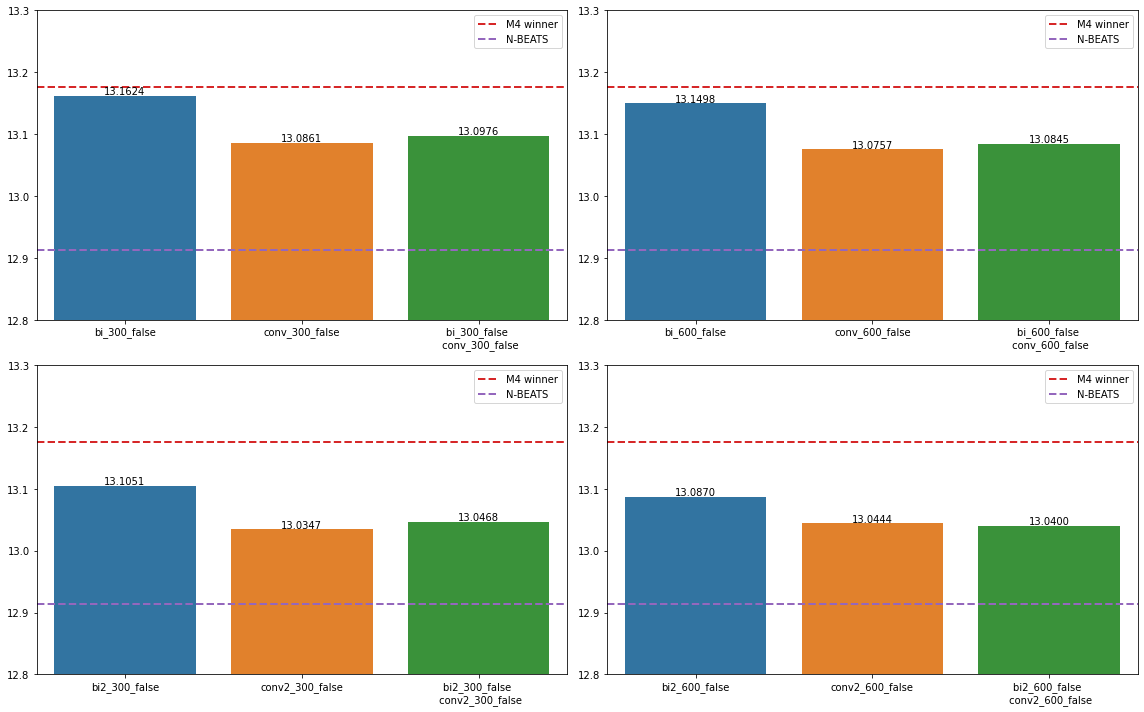

In [136]:
plt.figure(figsize=(16, 10))

ax = plt.subplot(221)
plot_ensemble_results('bi_300_false', 'conv_300_false', ax=ax)

ax = plt.subplot(222)
plot_ensemble_results('bi_600_false', 'conv_600_false', ax=ax)

ax = plt.subplot(223)
plot_ensemble_results('bi2_300_false', 'conv2_300_false', ax=ax)

ax = plt.subplot(224)
plot_ensemble_results('bi2_600_false', 'conv2_600_false', ax=ax)

plt.tight_layout()

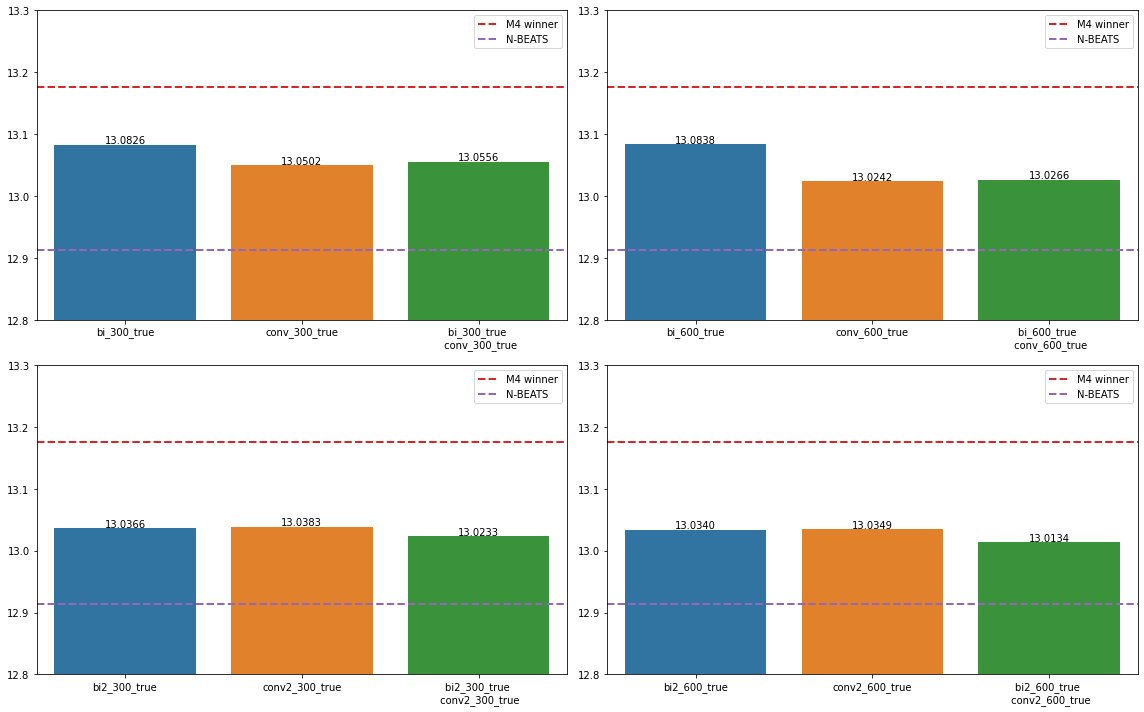

In [137]:
plt.figure(figsize=(16, 10))

ax = plt.subplot(221)
plot_ensemble_results('bi_300_true', 'conv_300_true', ax=ax)

ax = plt.subplot(222)
plot_ensemble_results('bi_600_true', 'conv_600_true', ax=ax)

ax = plt.subplot(223)
plot_ensemble_results('bi2_300_true', 'conv2_300_true', ax=ax)

ax = plt.subplot(224)
plot_ensemble_results('bi2_600_true', 'conv2_600_true', ax=ax)

plt.tight_layout()

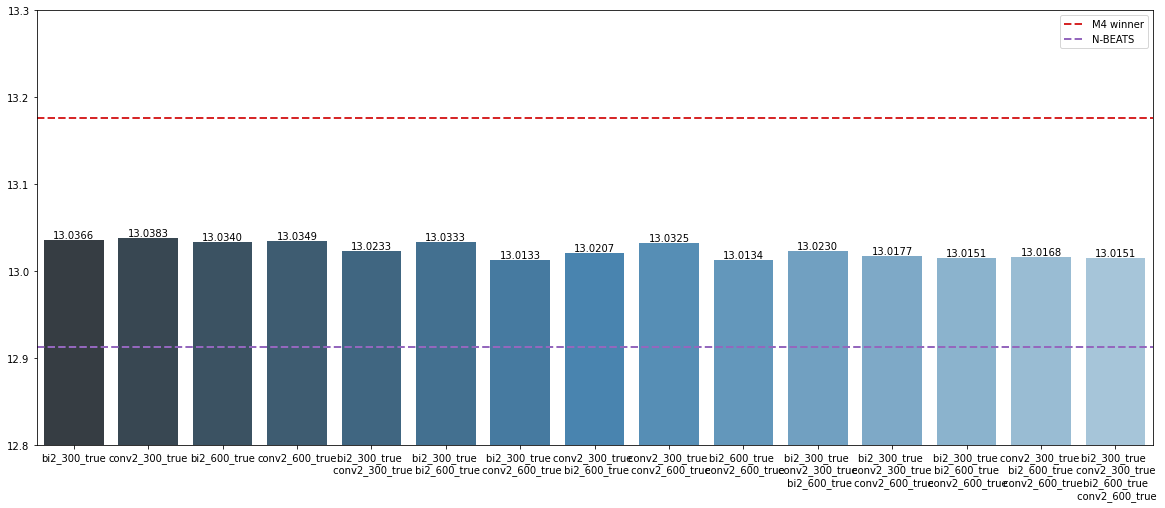

In [138]:
plt.figure(figsize=(20, 8))

plot_ensemble_results('bi2_300_true', 'conv2_300_true', 'bi2_600_true', 'conv2_600_true', palette='Blues_d')